# Reprojection

This notebook performs reprojections over raster data arrays on a local Dask Cluster. Through all steps of the tutorial, we will see how to:
- Lazily reproject GeoTIFFs in the cloud with `WarpedVRT` from `rasterio`, which is a python wrapper for GDAL.
- Reproject a DataArray to a new CRS with `stackstac` (no GDAL).

Note that these 2 methods only work on datasets that fit in-memory on a single node cluster, which we are going to use in this notebook. `WarpedVRT` will load input data into a dask array if param chunks is provided. `stackstac.reproject_array` also works with Dask but is sub-optimal. It is only recommended on arrays with a relatively small number spatial chunks.

Data using in this example is from Sentinel-2 satellite imagery. To create true color images for visualization, we use `true_color` function from `xrspatial.multispectral`

Let's get started by importing all necessary libraries.

In [1]:
import planetary_computer as pc
import pystac_client

import xarray as xr

import stackstac
from stackstac.raster_spec import RasterSpec

import affine
import rioxarray

import rasterio
from rasterio.vrt import WarpedVRT
import rasterio.crs
import pyproj.crs

import xrspatial.multispectral as ms
import matplotlib.pyplot as plt

## Local Dask Cluster

We use a small dataset so let's create a local Dask Cluster.

In [2]:
from dask.distributed import Client

client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


## Study data

The region of interest in this section is located in Colorado, USA, centered by Cochetopa Dome and Sawtooth Mountain. We first choose a single scene by its ID as below.

In [3]:
item_id = ["S2B_MSIL2A_20190924T175049_N0212_R141_T13SCC_20201004T164728.SAFE"]

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
search = catalog.search(collections=["sentinel-2-l2a"], ids=item_id)

item = [pc.sign_assets(i).to_dict() for i in search.items()][0]

item["properties"]["proj:epsg"]

32613

The selected scene is stored in `EPSG:32613` coordinate system. With [xrspatil.multispectral.true_color](https://xarray-spatial.org/reference/multispectral.html) function, we can create a true color image to see how the actual data looks like.

In [4]:
scene_data = stackstac.stack(
    item,
    assets=["B04", "B03", "B02"],
    resolution=100,
    chunksize=2048,
).isel(time=0)

scene_data

<xarray.DataArray 'stackstac-824a46348e374bbcd75188577fd70846' (band: 3, y: 1099, x: 1098)>
dask.array<getitem, shape=(3, 1099, 1098), dtype=float64, chunksize=(1, 1099, 1098), chunktype=numpy.ndarray>
Coordinates: (12/46)
    time                                     datetime64[ns] 2019-09-24T17:50:...
    id                                       <U65 'S2B_MSIL2A_20190924T175049...
  * band                                     (band) <U3 'B04' 'B03' 'B02'
  * x                                        (x) float64 3e+05 ... 4.097e+05
  * y                                        (y) float64 4.3e+06 ... 4.19e+06
    s2:datastrip_id                          <U64 'S2B_OPER_MSI_L2A_DS_ESRI_2...
    ...                                       ...
    title                                    (band) <U20 'Band 4 - Red - 10m'...
    proj:transform                           object {0.0, 300000.0, 10.0, 430...
    common_name                              (band) <U5 'red' 'green' 'blue'
    center_wavelength                        (band) float64 0.665 0.56 0.49
    full_width_half_max                      (band) float64 0.038 0.045 0.098
    epsg                                     int64 32613
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(300000, 4190200, 409800, 4300...
    crs:         epsg:32613
    transform:   | 100.00, 0.00, 300000.00|\n| 0.00,-100.00, 4300100.00|\n| 0...
    resolution:  100

In [5]:
scene_data = scene_data.compute()

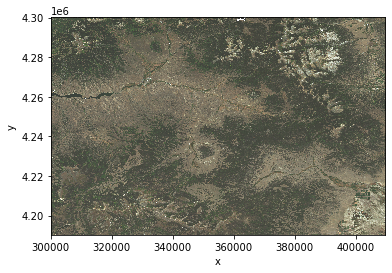

In [6]:
# visualize selected scene
scene_img = ms.true_color(*scene_data, name="epsg=32613")
scene_img.plot.imshow();

## Reproject with WarpedVRT

`WarpedVRT` does not require prior download of GeoTIFF files, we provide the URLs directly as the inputs. In following script, we fetch imagery from the Microsoft Sentinel-2 Azure Blob Storage and reproject them.

In [7]:
urls = {
    "red": item["assets"]["B04"]["href"],
    "green": item["assets"]["B03"]["href"],
    "blue": item["assets"]["B02"]["href"],
}

#### Web Mercator (EPSG:3857)

Web Mercator, the standard for Web mapping applications, is a variant of the Mercator projection. Its usage spans widely over major online map providers. In the below, we reproject our collected data from its source CRS of `EPSG:32613` to Web Mercator CRS of `EPSG:3857`

In [8]:
web_mecator_crs = rasterio.crs.CRS.from_epsg(3857)

web_mecator_reproj = []

for band, url in urls.items():
    with rasterio.open(url) as src:
        with WarpedVRT(src, src_crs=src.crs, crs=web_mecator_crs) as vrt:
            reproj = rioxarray.open_rasterio(vrt).chunk(
                {"x": 2048, "y": 2048, "band": 1}
            )
            web_mecator_reproj.append(reproj)

web_mecator_reproj = xr.concat(web_mecator_reproj, dim="band")
web_mecator_reproj

<xarray.DataArray (band: 3, y: 11199, x: 11154)>
dask.array<concatenate, shape=(3, 11199, 11154), dtype=uint16, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 1 1
  * x            (x) float64 -1.195e+07 -1.194e+07 ... -1.18e+07 -1.18e+07
  * y            (y) float64 4.699e+06 4.699e+06 ... 4.557e+06 4.557e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

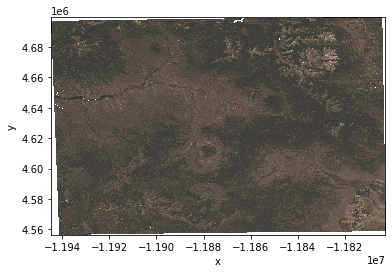

In [9]:
web_mecator_img = ms.true_color(*web_mecator_reproj, name="epsg=3857")
web_mecator_img.plot.imshow();

#### Robinson (ESRI:54030)

The Robinson projection is a map projection of a world map that does not preserve equal-area nor conformal. Both the lines of altitude and longitude are evenly spaced across the map for a compromise.

In this example, we use `ESRI:54030` as the target/destination CRS and demonstrate how to normalize a stack of images against a regular grid in a defined bounding box. In order to do that, we do following steps:
- Get rasterio CRS for `ESRI:54030`
- Define a shape (height, width), and bounding box (coords) for the target reprojected/destination image.
- Calculate transform to reproject from source CRS to destination CRS.
- Provide all above information to `WarpedVRT`, including: destination CRS, destination shape, and destination transform.
- Finally, do the projection.

In [10]:
robinson_crs = pyproj.crs.CRS.from_string("ESRI:54030")
robinson_crs = rasterio.crs.CRS.from_wkt(robinson_crs.to_wkt())
robinson_crs

CRS.from_wkt('PROJCS["World_Robinson",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Robinson"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","54030"]]')

In [11]:
height = width = 1000
robinson_bounds = (-9438051, 4153437, -9285636, 4046189)

# calculate destination transform
left, bottom, right, top = robinson_bounds
xres = (right - left) / width
yres = (top - bottom) / height
robinson_transform = affine.Affine(xres, 0.0, left, 0.0, -yres, top)

robinson_transform

Affine(152.415, 0.0, -9438051.0,
       0.0, 107.248, 4046189.0)

In [12]:
robinson_vrt_options = {
    "crs": robinson_crs,
    "transform": robinson_transform,
    "height": height,
    "width": width,
}

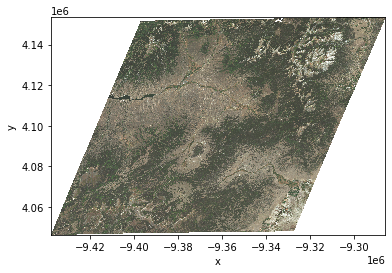

In [13]:
robinson_reproj = []

for _, url in urls.items():
    with rasterio.open(url) as src:
        with WarpedVRT(src, **robinson_vrt_options) as vrt:
            reproj = rioxarray.open_rasterio(vrt).chunk(
                {"x": 1000, "y": 1000, "band": 1}
            )
            robinson_reproj.append(reproj)

robinson_reproj = xr.concat(robinson_reproj, dim="band")

# visualize
robinson_img = ms.true_color(*robinson_reproj, name="esri=54030")
robinson_img.plot.imshow();

### Reproject with `stackstac`

`stackstac` provides a tool called `reproject_array` that uses `scipy.interpolate.interpn` internally to reproject and clip a `xarray.DataArray` to a new destination CRS. No GDAL dependency required. `reproject_array` takes a DataArray as input data, we'll use the scene data created from the beginning to do experiments in this section.

#### Space Oblique (EPSG: 29873)

Space Oblique is a projection especially designed for satellite imagery so that it is completely free of distortion along the orbit path of the satellite.

In [14]:
space_oblique_crs = 29873
space_oblique_bounds = stackstac.array_bounds(scene_data, space_oblique_crs)

space_oblique_spec = RasterSpec(
    epsg=space_oblique_crs, bounds=space_oblique_bounds, resolutions_xy=(100, 100)
)

space_oblique_spec

RasterSpec(epsg=29873, bounds=(10675043.061755113, 9759787.611046724, 10821810.348856306, 9906505.13592516), resolutions_xy=(100, 100))

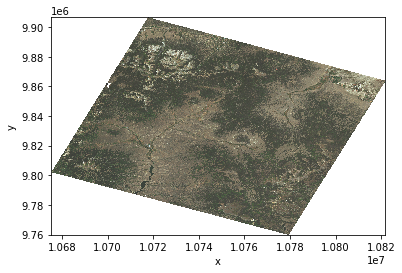

In [15]:
space_oblique_reproj = stackstac.reproject_array(scene_data, space_oblique_spec)

space_oblique_img = ms.true_color(*space_oblique_reproj, name="epsg=29873")
space_oblique_img.plot.imshow();

#### Lambert Cylindrical Projection (EPSG: 6933)

Lambert Cylindrical is an equal area projection, a map projection that preserves area measure. Regions with the same size on the Earth have the same size on the map but generally distort the shape, angle, and scale.

In [16]:
cylindrical_crs = 6933
cylindrical_bounds = stackstac.array_bounds(scene_data, cylindrical_crs)
cylindrical_bounds

(-10353359.384616517,
 4491297.738205519,
 -10229990.096052434,
 4592655.192300517)

In [17]:
cylindrical_spec = RasterSpec(
    epsg=cylindrical_crs, bounds=cylindrical_bounds, resolutions_xy=(100, 100)
)

cylindrical_spec

RasterSpec(epsg=6933, bounds=(-10353359.384616517, 4491297.738205519, -10229990.096052434, 4592655.192300517), resolutions_xy=(100, 100))

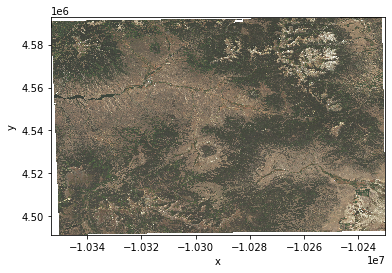

In [18]:
cylindrical_reproj = stackstac.reproject_array(scene_data, cylindrical_spec)

cylindrical_img = ms.true_color(*cylindrical_reproj, name="epsg=6933")
cylindrical_img.plot.imshow();

### Show results

Let's plot all images and put them side by side to have an overview of what we have done so far.

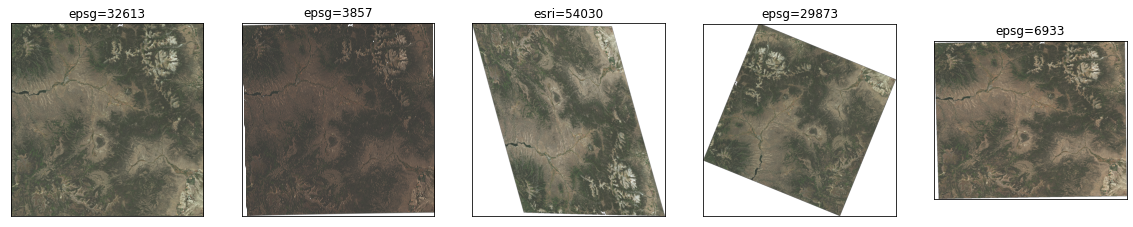

In [19]:
imgs = [scene_img, web_mecator_img, robinson_img, space_oblique_img, cylindrical_img]

fig, ax = plt.subplots(nrows=1, ncols=len(imgs), figsize=(20, 15))
for i in range(len(imgs)):
    ax[i].imshow(imgs[i].data)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(imgs[i].name)

plt.show()